[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lucashofer/atomcloud/blob/main/docs/notebooks/Multi_Level_Fits.ipynb)

# Multi-Level Fits

Here we show how to piece together the different fits to create a multi-level fit.

We recommend first going through at least the Multi-Function and Multi-Function Fit notebooks before this one; the 2D Sum-Fit notebook is also useful.

First, let's install AtomCloud and JAXFit (for GPU acceleration).

In [ ]:
!pip install jaxfit
!pip install atomcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 13.2 MB/s eta 0:00:00


Let's get some example data of a bimodal distribution and plot the data

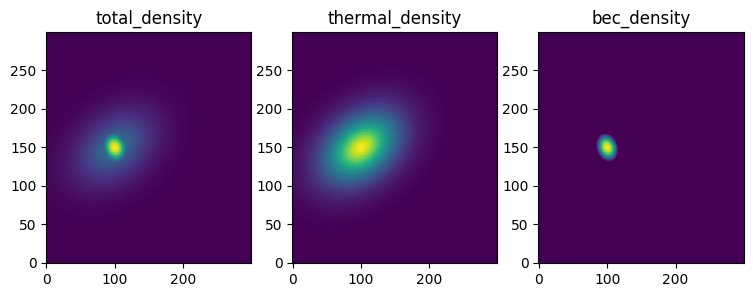

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from atomcloud import example_data

XY_tuple, densities, parameters = example_data.get_example_data()
total_density, thermal_density, bec_density, offset = densities

labels = ['total_density', 'thermal_density', 'bec_density']

fig, axes = plt.subplots(1, 3, figsize = (9, 3))

for ax, density, label in zip(axes, densities, labels):
    ax.pcolormesh(*XY_tuple, density,shading='auto')
    ax.set_title(label)

Now it previous notebooks we showed how to apply a 1D fit to the data summed along the x and y axes, respectively. We did this with the basic 1D fit funtion as well as the 2D Sum-Fit function, which automatically sums the data along the x and y axes and fits the resulting 1D data. Additionally, we showed how to apply a 2D fit to the data.

In the multi-function fit notebook, we demonstrated that for more complex fits we can use more basic fits to seed the more complex ones. However, this was done in a basic way.

AtomCloud includes code to create multi-level fits, which are useful for the complex fitting routines we often need when analyzing cold atom clouds. Furthermore, all the processing (e.g. rescaling the data, integrating the data, calculating the lab widths) is done automatically. This means we can rapidly create complex fits and extract the parameters we need---all with the power of GPU acceleration due to the internal use of JAX and JAXFit.

Below we'll show how to create a multi-level fit using the basic fitting objects from the previous notebooks. After that, we'll show how to create a multi-level fit object to massively simplify the process.

## Manual Multi-Level Fit

Here we'll use the basic fitting objects to create a multi-level fit.

We'll fit the bimodal data with three different levels of fits. The first will be a 2D SumFit of a simple Gaussian---this will give us rough dimensions of the distribution and its center. We will then use these values to create a full 2D Gaussian fit, which will give us additional information regarding the angle of the distribution. Finally, we'll apply a full 2D fit of a bimodal distribution to get the parameters of the thermal cloud as well as the condensate.

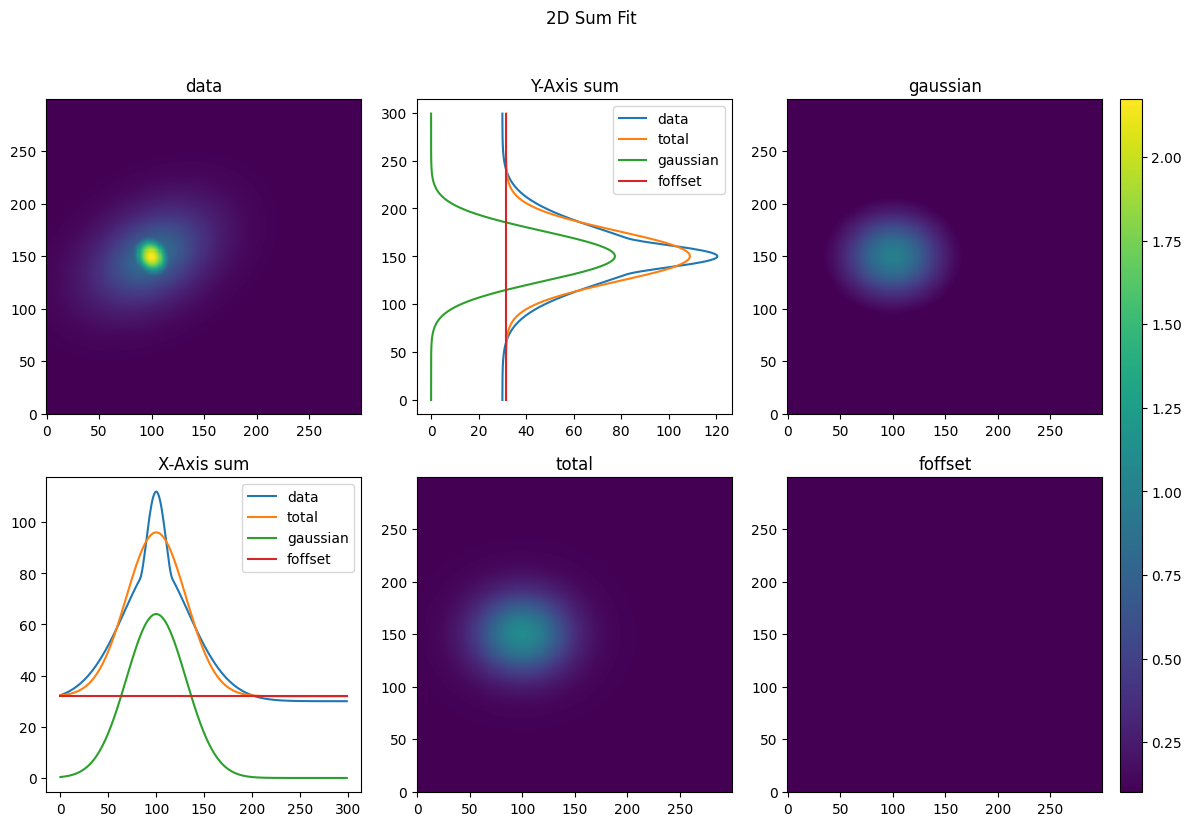

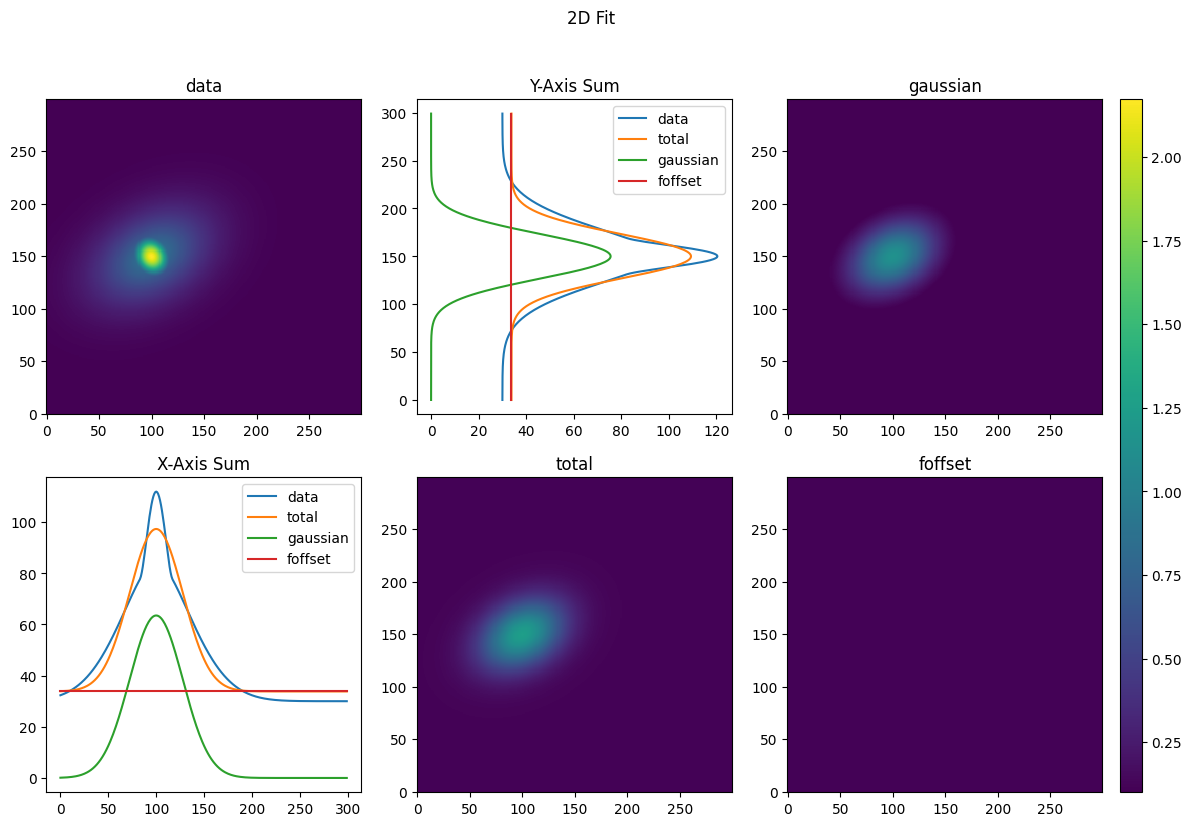

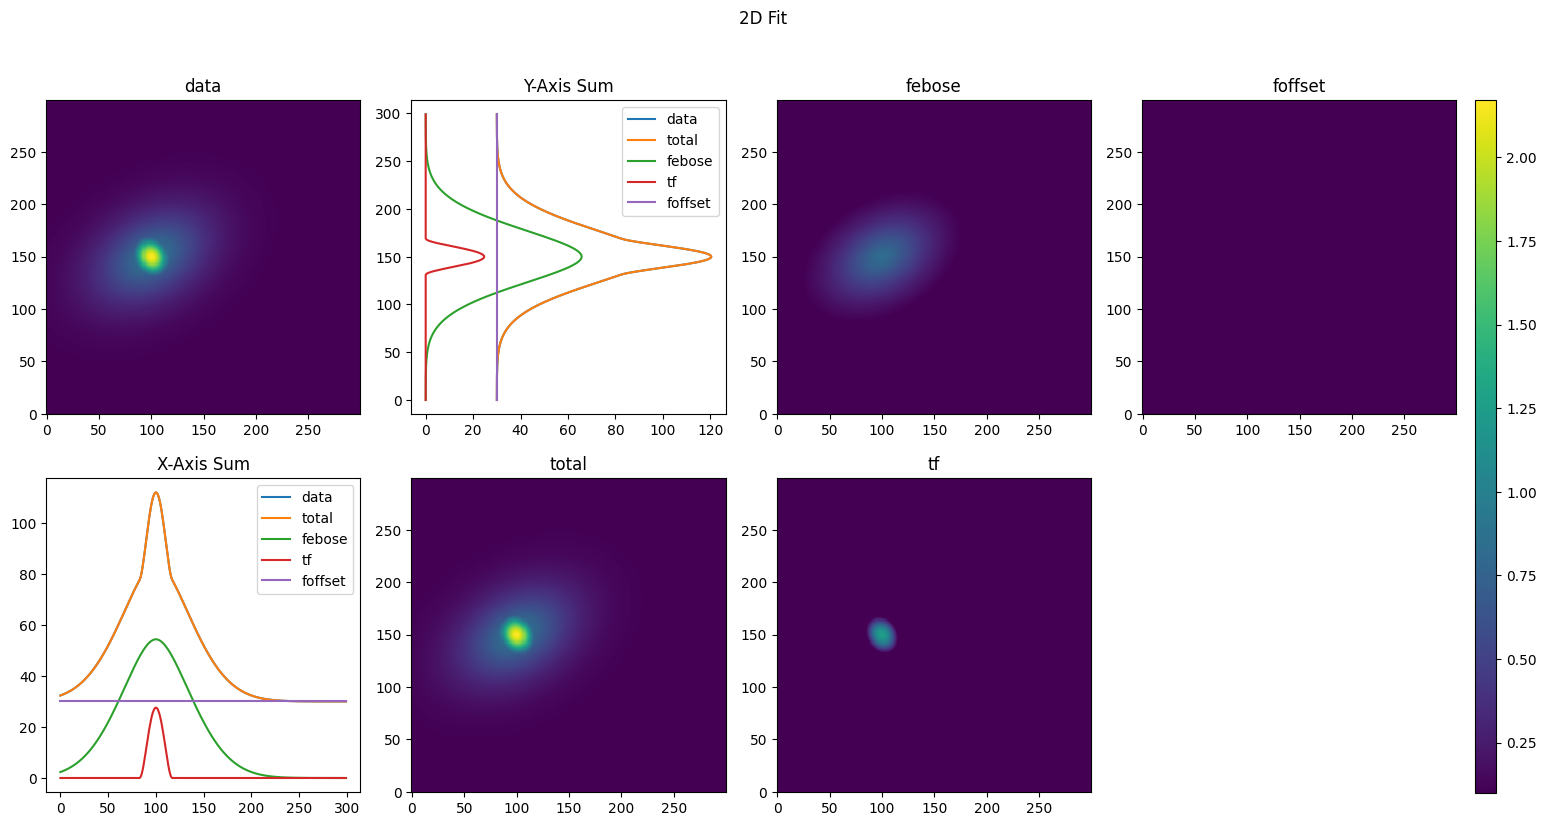

In [ ]:
from atomcloud.fits import SumFit2D, MultiFit2D
from atomcloud.process_fits import plot_fitdict

#set fit object equations and constraints
gauss1d_eqs = ['gaussian', 'foffset']
gauss2d_eqs = gauss1d_eqs
bimodal_eqs = ['febose', 'tf', 'foffset']
bimodal_cons = ['x0', 'y0', 'theta']

#instantiates fit objects
gauss_sfit_obj = SumFit2D(gauss1d_eqs)
gauss_2dfit_obj = MultiFit2D(gauss2d_eqs)
bimodal_2dfit_obj = MultiFit2D(bimodal_eqs)

#fit the data
_, gauss_sfit_dict = gauss_sfit_obj.get_fit(XY_tuple, total_density)

gauss_2d_seed = gauss_sfit_dict['2d']['params']

_, gauss_2dfit_dict = gauss_2dfit_obj.get_fit(XY_tuple, total_density,
                                              gauss_2d_seed)

#create bimodal seed
gauss_params, offset_params = gauss_2dfit_dict['params']
parabola_params = gauss_params.copy()
parabola_params[3] /= 2
parabola_params[4] /= 2
bimodal_seed = [gauss_params, parabola_params, offset_params]

_, bimodal_2dfit_dict = bimodal_2dfit_obj.get_fit(XY_tuple, total_density,
                                                  bimodal_seed)

#plot the fits
plot_fitdict(gauss_sfit_dict, XY_tuple, total_density)
plot_fitdict(gauss_2dfit_dict, XY_tuple, total_density)
plot_fitdict(bimodal_2dfit_dict, XY_tuple, total_density)

That wasn't too bad for this simple fit. However, we've neglected to include arguments for the GPU acceleration of the fit objects. Furthermore, we haven't included any more advanced features for the fits, such as masks. If we want to add these features, the code can quickly become unwieldy---particularly for more complex fits.

## Mixed-Level Fit Object

Now let's do the same fit using the MultiLevelFit object.

In [ ]:
from atomcloud.mixed_level import fit_level, MixedLevelBase


class SimpleBimodal(MixedLevelBase):

    fit_order = ["gsum", "gauss2d", "bimodal"]

    @fit_level("SumFit2D",
               ["gaussian", "foffset"])
    def gsum(self, coords, data, seed=None, mask=None):
        return coords, data, seed, mask

    @fit_level("2DFit",
               ["gaussian", "foffset"])
    def gauss2d(self, coords, data, seed=None, mask=None):
        gauss_2d_seed = self.level_fits['gsum']['2d']['params']
        return coords, data, gauss_2d_seed, mask

    @fit_level("2DFit",
               ["febose", "tf", "foffset"],
               ['x0', 'y0', 'theta'])
    def bimodal(self, coords, data, seed=None, mask=None):
        gauss_params, offset_params = self.level_fits['gauss2d']['params']
        parabola_params = gauss_params.copy()
        parabola_params[3] /= 2
        parabola_params[4] /= 2
        bimodal_seed = [gauss_params, parabola_params, offset_params]
        return coords, data, bimodal_seed, mask

mixed_fit_obj = SimpleBimodal(scipy_length=1e3, fixed_length=600**2)
_, fit_info = mixed_fit_obj.get_fit(XY_tuple, total_density, save_data=True)

Alright that fit, but let's break down what's going on here. Firstly, the multi-level objects must always inherit from the MixedLevelBase class. This class has all the under-the-hood code to make the multi-level fit work.

The class variable fit_order is a list of the order in which the fits should be exectued. Furthermore each name in the list must correspond to a function in the object.

Each of these object functions needs to have the @fit_level operator decorating it. The fit_level decorator takes two required arguments and one optional one. The first is the type of multi-fit object to use and can be either 1DFit, 2DFit or SumFit2D. The second is the list of equations to use in the multi-function fit. The optional argument is a list of constraints to apply to the fit.

Behind the scenes the decorator handles instantiating the fit objects with the supplied equations and constraints.

Finally, the actual function below the decorator is the code that is called before the fit is executed. This is where we can do any pre-processing of the data that we need to do. The function must always return coords, data seed, mask. As the multi-level object expects these return values. Furthermore, the input arguments to the function should be the same as shown above.

In order to access values from a previous fit, we can use self.level_fit. This class variable is a dictionary where its keys are the previous levels function names and its values are the fit_dicts from the previous levels.

Finally, flagging save_data=True will save the data from each level of the fit. This is useful for debugging and for plotting the fits, but can take up a lot of memory if you are fitting hudreds of images. The plotting works similar to the plotting of the basic fit objects.

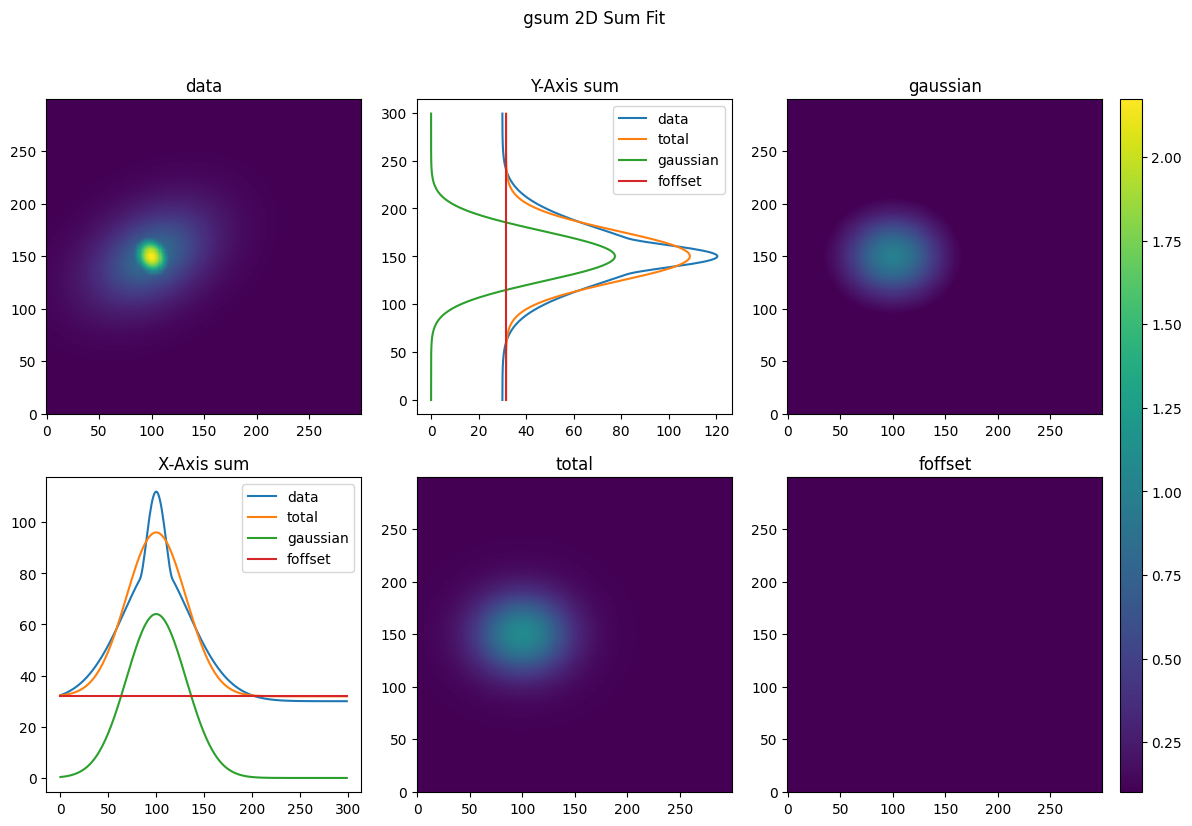

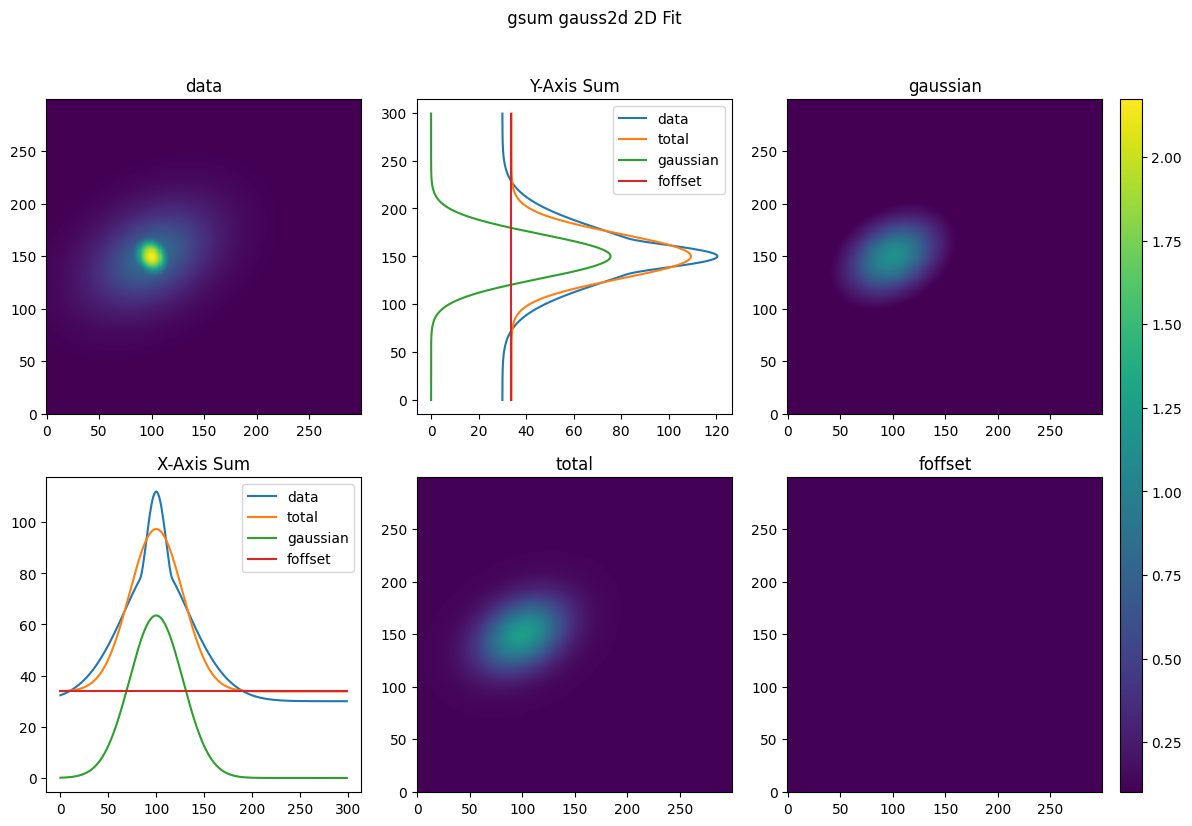

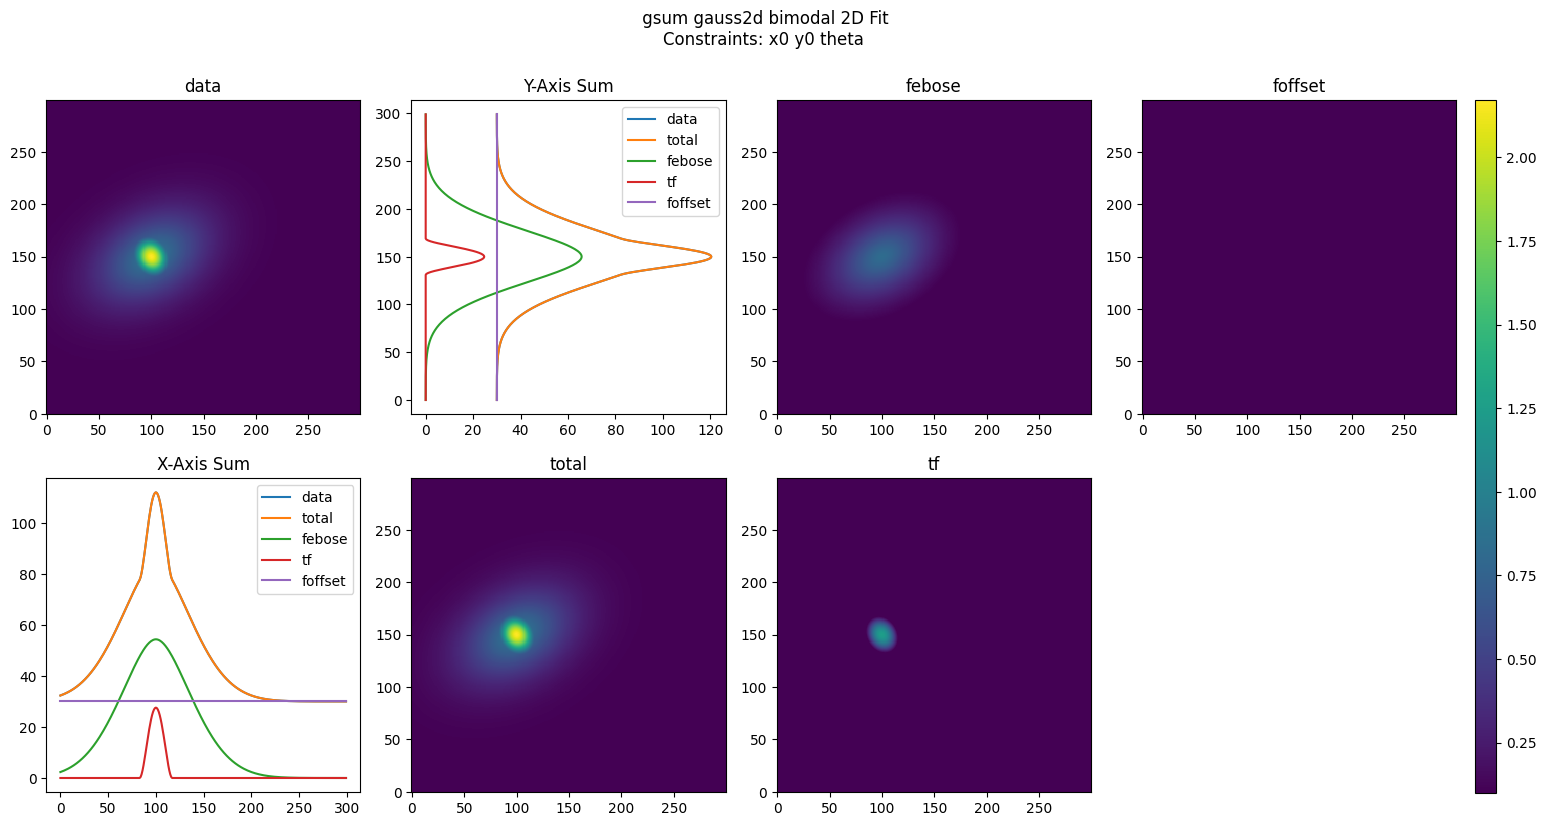

In [ ]:
from atomcloud.process_fits import plot_fitdict

fit_dicts = fit_info['fitdicts']
data = fit_info['data']
coords = fit_info['coords']
mask = fit_info['masks']

plot_fitdict(fit_dicts, coords, data, mask=mask)

Finally, we can rescale and analyze the data as with the basic fit objects; however, now the analysis is performed at every fit level.

In [ ]:
from atomcloud.process_fits import process_fitdict

scale_dict = {'xscale': 1.5,
              'yscale': 1.5,
              'zscale': 2}

analyzed_fit_dict = process_fitdict(fit_dicts,
                                    scale_dict=scale_dict,
                                    analyze=True)

for level, fit_dict in analyzed_fit_dict.items():
    print(level)
    for key, value in fit_dict.items():
        print(key, value)
        print('-' *15)
    print('-'*30)

gsum
2d {'fit_type': 'cloud2d', 'equations': ['gaussian', 'foffset'], 'constraints': None, 'params': [[1.96396503378406, 149.9971422371304, 225.16985553653888, 46.63887902767835, 39.4693413292194, 0], [0.21155635741126447]], 'data_sum': 65548.72816805683, 'analysis_params': [{'sigxx': 46.63887902767835, 'sigyy': 39.4693413292194, 'int': 22715.46346461524}, {}]}
---------------
xsum {'fit_type': '1d', 'equations': ['gaussian', 'foffset'], 'constraints': None, 'params': [[128.15160874040214, 46.63887902767835, 149.9971422371304], [63.83692043886187]], 'fit_metrics': {'chi_squared': 5766.650373726157, 'chi_squared_red': 19.351175750758916}, 'data_sum': 65548.72816805681, 'analysis_params': [{'int': 14981.734628958917}, {}]}
---------------
ysum {'fit_type': '1d', 'equations': ['gaussian', 'foffset'], 'constraints': None, 'params': [[154.70313945926077, 39.4693413292194, 225.16985553653888], [63.096894007896815]], 'fit_metrics': {'chi_squared': 4002.643125909777, 'chi_squared_red': 13.4316

The fit_dicts for a given fit level can be flatted with the row_format flag. However, in order to flatten to a single dictionary, we need to guarantee unique names for each parameter. Thus, the equation names are appended to the front of the variable key.

In [ ]:
analyzed_fit_dict = process_fitdict(fit_dicts,
                                    scale_dict=scale_dict,
                                    analyze=True,
                                    row_format=True)

for level, fit_dict in analyzed_fit_dict.items():
    print(level)
    print(fit_dict)

gsum
{'2d_data_sum': 65548.72816805683, '2d_gaussian_n0': 1.96396503378406, '2d_gaussian_x0': 149.9971422371304, '2d_gaussian_y0': 225.16985553653888, '2d_gaussian_sigx': 46.63887902767835, '2d_gaussian_sigy': 39.4693413292194, '2d_gaussian_theta': 0, '2d_gaussian_sigxx': 46.63887902767835, '2d_gaussian_sigyy': 39.4693413292194, '2d_gaussian_int': 22715.46346461524, '2d_foffset_foff': 0.21155635741126447, 'xsum_data_sum': 65548.72816805681, 'xsum_chi_squared': 5766.650373726157, 'xsum_chi_squared_red': 19.351175750758916, 'xsum_gaussian_n0': 128.15160874040214, 'xsum_gaussian_sig': 46.63887902767835, 'xsum_gaussian_x0': 149.9971422371304, 'xsum_gaussian_int': 14981.734628958917, 'xsum_foffset_foff': 63.83692043886187, 'ysum_data_sum': 65548.72816805683, 'ysum_chi_squared': 4002.643125909777, 'ysum_chi_squared_red': 13.431688341979118, 'ysum_gaussian_n0': 154.70313945926077, 'ysum_gaussian_sig': 39.4693413292194, 'ysum_gaussian_x0': 225.16985553653888, 'ysum_gaussian_int': 15305.5499905

They can completely flattened with the total_flatten flag. Again to guarantee the uniqueness of the key, the fit level name (i.e. gsum) is appended to the front of the variable keys

In [ ]:
analyzed_fit_dict = process_fitdict(fit_dicts,
                                    scale_dict=scale_dict,
                                    analyze=True,
                                    row_format=True,
                                    total_flatten=True)

analyzed_fit_dict

{'gsum_2d_data_sum': 65548.72816805683,
 'gsum_2d_gaussian_n0': 1.96396503378406,
 'gsum_2d_gaussian_x0': 149.9971422371304,
 'gsum_2d_gaussian_y0': 225.16985553653888,
 'gsum_2d_gaussian_sigx': 46.63887902767835,
 'gsum_2d_gaussian_sigy': 39.4693413292194,
 'gsum_2d_gaussian_theta': 0,
 'gsum_2d_gaussian_sigxx': 46.63887902767835,
 'gsum_2d_gaussian_sigyy': 39.4693413292194,
 'gsum_2d_gaussian_int': 22715.46346461524,
 'gsum_2d_foffset_foff': 0.21155635741126447,
 'gsum_xsum_data_sum': 65548.72816805681,
 'gsum_xsum_chi_squared': 5766.650373726157,
 'gsum_xsum_chi_squared_red': 19.351175750758916,
 'gsum_xsum_gaussian_n0': 128.15160874040214,
 'gsum_xsum_gaussian_sig': 46.63887902767835,
 'gsum_xsum_gaussian_x0': 149.9971422371304,
 'gsum_xsum_gaussian_int': 14981.734628958917,
 'gsum_xsum_foffset_foff': 63.83692043886187,
 'gsum_ysum_data_sum': 65548.72816805683,
 'gsum_ysum_chi_squared': 4002.643125909777,
 'gsum_ysum_chi_squared_red': 13.431688341979118,
 'gsum_ysum_gaussian_n0': 1

This totally flattened dictionary can now be loaded easily into a pandas dataframe row

In [ ]:
import pandas as pd

fit_df = pd.DataFrame([analyzed_fit_dict])
fit_df

,gsum_2d_data_sum,gsum_2d_gaussian_n0,gsum_2d_gaussian_x0,gsum_2d_gaussian_y0,gsum_2d_gaussian_sigx,gsum_2d_gaussian_sigy,gsum_2d_gaussian_theta,gsum_2d_gaussian_sigxx,gsum_2d_gaussian_sigyy,gsum_2d_gaussian_int,...,bimodal_tf_n0,bimodal_tf_x0,bimodal_tf_y0,bimodal_tf_rx,bimodal_tf_ry,bimodal_tf_theta,bimodal_tf_rxx,bimodal_tf_ryy,bimodal_tf_int,bimodal_foffset_foff
0,65548.728168,1.963965,149.997142,225.169856,46.638879,39.469341,0,46.638879,39.469341,22715.463465,...,2.5,150.0,225.0,24.0,30.0,-0.523599,25.632011,28.618176,2261.946711,0.2


Thus, if we have multiple images we are fitting, we can easily analyze each one and then add it as a row in the DataFrame. This is useful for analyzing large datasets. There's one function which makes this easier.

Let's say for instance we perform five fits on different images (here we will use the same data for simplicity).

In [ ]:
from atomcloud.process_fits import process_all_fitdicts

all_fit_info = {}
for run in range(5):
    _, fit_info = mixed_fit_obj.get_fit(XY_tuple, total_density)
    all_fit_info[run] = fit_info

fit_dicts = {run: fit_info['fitdicts'] for run, fit_info in all_fit_info.items()}

tdicts = process_all_fitdicts(fit_dicts, scale_dict, analyze=True,
                              row_format=True, total_flatten=True)

tdf = pd.DataFrame(tdicts).transpose()
tdf

,gsum_2d_data_sum,gsum_2d_gaussian_n0,gsum_2d_gaussian_x0,gsum_2d_gaussian_y0,gsum_2d_gaussian_sigx,gsum_2d_gaussian_sigy,gsum_2d_gaussian_theta,gsum_2d_gaussian_sigxx,gsum_2d_gaussian_sigyy,gsum_2d_gaussian_int,...,bimodal_tf_n0,bimodal_tf_x0,bimodal_tf_y0,bimodal_tf_rx,bimodal_tf_ry,bimodal_tf_theta,bimodal_tf_rxx,bimodal_tf_ryy,bimodal_tf_int,bimodal_foffset_foff
0,65548.728168,1.963965,149.997142,225.169856,46.638879,39.469341,0.0,46.638879,39.469341,22715.463465,...,2.5,150.0,225.0,24.0,30.0,-0.523599,25.632011,28.618176,2261.946711,0.2
1,65548.728168,1.963965,149.997142,225.169856,46.638879,39.469341,0.0,46.638879,39.469341,22715.463465,...,2.5,150.0,225.0,24.0,30.0,-0.523599,25.632011,28.618176,2261.946711,0.2
2,65548.728168,1.963965,149.997142,225.169856,46.638879,39.469341,0.0,46.638879,39.469341,22715.463465,...,2.5,150.0,225.0,24.0,30.0,-0.523599,25.632011,28.618176,2261.946711,0.2
3,65548.728168,1.963965,149.997142,225.169856,46.638879,39.469341,0.0,46.638879,39.469341,22715.463465,...,2.5,150.0,225.0,24.0,30.0,-0.523599,25.632011,28.618176,2261.946711,0.2
4,65548.728168,1.963965,149.997142,225.169856,46.638879,39.469341,0.0,46.638879,39.469341,22715.463465,...,2.5,150.0,225.0,24.0,30.0,-0.523599,25.632011,28.618176,2261.946711,0.2


## Complex Example

In the above example the fit was relatively simple as we were working with artifical data that had a well defined thermal and condensate component. However, in real data the condensate can often be quite small and a bimodal fit will struggle to identify it.

For these reasons we often use a more complex fit to identify the condensate. Essentially we mask out the condensate and first fit the thermal cloud. We then subtract the thermal cloud from the data and fit the condensate. Finally, we add the two fits together to get the total fit.

In [ ]:
from atomcloud.utils import fit_utils, mask_utils

class ComplexBimodal(MixedLevelBase):

    fit_order = ['gsum', 'thermal', 'parsum', 'bec', 'bimodal']


    def get_fit(self, coords, data, *args, **kwargs):
        # override parent get fit method to add bec sums
        self.thermal_passed = False
        fit_passed, fit_info = super().get_fit(coords, data, *args, **kwargs)
        fit_info['bec_sum'] = self.bec_sums(coords, data)
        return self.thermal_passed, fit_info

    @fit_level('SumFit2D',
               ['gaussian', 'foffset'])
    def gsum(self, coords, data, seed=None, mask=None):
        return coords, data, seed, mask

    @fit_level('2DFit',
               ['febose', 'foffset'])
    def thermal(self, coords, data, seed=None, mask=None):
        params_2d = self.level_fits['gsum']['2d']['params']

        #get elliptical mask
        gauss_params, _ = params_2d
        gauss_centroid = gauss_params[1:3]
        mask_width_angle = self.kwargs['mask_params']
        mask_params = gauss_centroid + mask_width_angle
        if 'scalar' in self.kwargs.keys():
            scalar = self.kwargs['scalar']
        else:
            scalar = 1.0

        self.bec_mask = fit_utils.generate_elliptical_mask2D(coords,
                                                             *mask_params,
                                                             scale=scalar)
        thermal_mask = ~self.bec_mask  # invert mask to exclude the BEC
        return coords, data, params_2d, thermal_mask

    @fit_level('SumFit2D',
               ['parabola', 'foffset'])
    def parsum(self, coords, data, seed=None, mask=None):
        self.thermal_passed = True
        gsumx_params = self.level_fits['gsum']['xsum']['params']
        gsumy_params = self.level_fits['gsum']['ysum']['params']
        gsumx_params[0][1] = 7.5
        gsumy_params[0][1] = 7.5
        seed = [gsumx_params, gsumy_params]

        thermal_params = self.level_fits['thermal']['params']
        fit_func = self.level_fit_objs['thermal'].func
        thermal_density = fit_func(coords, thermal_params)
        self.bec_density = data - thermal_density
        square_mask = mask_utils.find_square_mask(self.bec_mask)
        return coords, self.bec_density, seed, square_mask

    @fit_level('2DFit',
               ['tf'])
    def bec(self, coords, data, seed=None, mask=None):
        params2d = self.level_fits['parsum']['2d']['params']
        bec_param, _ = params2d
        bec_seed = [bec_param]
        return coords, self.bec_density, bec_seed, self.bec_mask

    @fit_level('2DFit',
               ['febose', 'tf', 'foffset'],
               ['x0', 'y0', 'theta'])
    def bimodal(self, coords, data, seed=None, mask=None):
        thermal_params = self.level_fits['thermal']['params']
        febose_params, off_params = thermal_params
        bec_params = self.level_fits['bec']['params'][0]
        seed = [febose_params, bec_params, off_params]
        return coords, data, seed, mask


    def bec_sums(self, coords, data):
        level_bec_sum = {}
        for key in self.level_fits.keys():
            if 'thermal' in key:
                thermal_params = self.level_fits[key]['params']
                fit_func = self.level_fit_objs[key].func
                thermal_density = fit_func(coords, thermal_params)
                bec_density = data - thermal_density
                mask = self.bec_mask
                level_bec_sum[key] = np.sum(bec_density[mask])
        return level_bec_sum

Although this is still a bit long, it is 2-3 times shorter than manually coding the entire fit routine with the multi-function fit objects.

## GPU vs. CPU Comparison

With this more realistic fitting procedure we'll instantiate both JAXFit and Scipy fit objects which use the GPU and CPU, respectively. First we'll create an experiment sized image of 500x500 image which is a realistic image size we'd encounter in an experiment

In [ ]:
coords, densities, _ = example_data.get_example_data(500)
bimodal_density, _, _, _ = densities

Scipy 0 of 5
Scipy 1 of 5
Scipy 2 of 5
Scipy 3 of 5
Scipy 4 of 5
JAXFit 0 of 5
JAXFit 1 of 5
JAXFit 2 of 5
JAXFit 3 of 5
JAXFit 4 of 5
SciPy Average:  5.339378535747528
JAXFit Average:  0.3250747323036194


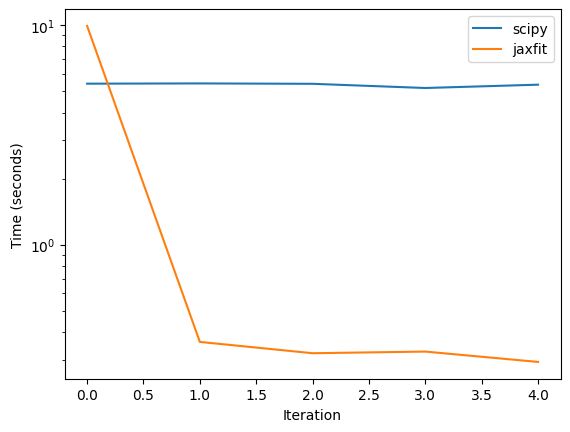

In [ ]:
import time

scale = 1
mask_params = [25, 25, 0] #sigx, sigy, theta

bimodal_scipy_obj = ComplexBimodal(scipy_length=np.inf)
bimodal_jax_obj = ComplexBimodal(scipy_length=3e3)


scipy_times = []
jaxfit_times = []

num_samples = 5
for i in range(num_samples):
    print('Scipy', i, 'of', num_samples)
    scipy_time = time.time()
    params, scipy_fit_dict = bimodal_scipy_obj.get_fit(coords, bimodal_density,
                                                       scale=scale,
                                                       mask_params=mask_params)
    scipy_times.append(time.time() - scipy_time)

for i in range(num_samples):
    print('JAXFit', i, 'of', num_samples)
    jaxfit_time = time.time()
    params, jax_fit_dict = bimodal_jax_obj.get_fit(coords, bimodal_density,
                                                   scale=scale,
                                                   mask_params=mask_params)
    jaxfit_times.append(time.time() - jaxfit_time)


print('SciPy Average: ', np.mean(scipy_times[1:]))
print('JAXFit Average: ', np.mean(jaxfit_times[1:]))

plt.figure()
plt.plot(scipy_times, label='scipy')
plt.plot(jaxfit_times, label='jaxfit')
plt.yscale("log")
plt.xlabel('Iteration')
plt.ylabel('Time (seconds)')
plt.legend()
plt.show()

In [ ]:
jaxfit_times
# scipy_times

[9.915690183639526,
 0.36095285415649414,
 0.3205749988555908,
 0.3261451721191406,
 0.29262590408325195]

As we can see, with the GPU AtomCloud is able to achieve significantly over an order of magnitude increase in the fit speed. This allows us to perform complex fit routines not possible previously.